In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.core.pylabtools import figsize

figsize(12, 8)
plt.style.use('seaborn-colorblind')
sns.set()

## EDA

In [3]:
train_df = pd.read_csv('./train.csv')
train_df.drop('Unnamed: 0', axis=1, inplace=True)
len(train_df.columns)

166

In [4]:
test_df = pd.read_csv('./test.csv')
len(test_df.columns)

47

In [5]:
test_labels = test_df.columns.values.tolist()
tidy_train = train_df[test_labels]
tidy_train.shape[1]

47

In [6]:
label = 'NU_NOTA_MT'

tidy_train[label] = train_df[label]
tidy_train.shape[1]

48

In [7]:
labels = tidy_train.columns.tolist()
numeric_labels = tidy_train._get_numeric_data().columns.tolist()

missing_df = pd.DataFrame({
    'type': tidy_train.dtypes,
    'NA_sum': tidy_train.isna().sum(),
    'missing': tidy_train.isna().sum() / tidy_train.shape[0],
    'unique': tidy_train.nunique()
})

missing_df.sort_values(by ='missing', ascending=False)[:14]

,type,NA_sum,missing,unique
TP_DEPENDENCIA_ADM_ESC,float64,9448,0.688128,4
TP_ENSINO,float64,9448,0.688128,3
Q027,object,7373,0.536999,13
NU_NOTA_REDACAO,float64,3597,0.261981,53
NU_NOTA_LC,float64,3597,0.261981,2774
TP_STATUS_REDACAO,float64,3597,0.261981,9
NU_NOTA_COMP1,float64,3597,0.261981,15
NU_NOTA_COMP2,float64,3597,0.261981,13
NU_NOTA_COMP3,float64,3597,0.261981,12
NU_NOTA_COMP4,float64,3597,0.261981,14


In [8]:
categoric_labels = list(set(labels) - set(numeric_labels))
categoric_labels

['CO_PROVA_MT',
 'Q024',
 'CO_PROVA_LC',
 'Q027',
 'Q006',
 'SG_UF_RESIDENCIA',
 'Q026',
 'Q047',
 'CO_PROVA_CN',
 'Q002',
 'NU_INSCRICAO',
 'Q025',
 'TP_SEXO',
 'Q001',
 'CO_PROVA_CH']

In [9]:
filtered = []
for i in numeric_labels:
    if 'NU_NOTA' in i:
        filtered.append(i)

filtered

['NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'NU_NOTA_MT']

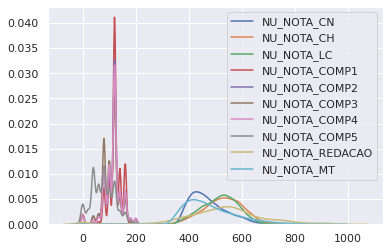

In [10]:
for name in filtered:
    sns.distplot(tidy_train[name], hist=False, label=str(name))
plt.xlabel("");

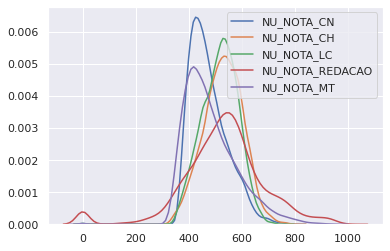

In [11]:
filtered = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_MT']
for name in filtered:
    sns.distplot(tidy_train[name], hist=False, label=str(name))
plt.xlabel("");

In [12]:
numeric_correlation = tidy_train[numeric_labels].corr(method='pearson')
numeric_correlation[label].sort_values(ascending=False)[2:]

NU_NOTA_CH                0.529594
NU_NOTA_LC                0.494695
NU_NOTA_REDACAO           0.379376
TP_DEPENDENCIA_ADM_ESC    0.373233
NU_NOTA_COMP3             0.350307
NU_NOTA_COMP5             0.343337
NU_NOTA_COMP4             0.342282
NU_NOTA_COMP2             0.335638
NU_NOTA_COMP1             0.299402
CO_UF_RESIDENCIA          0.107493
TP_ESCOLA                 0.069304
TP_ANO_CONCLUIU           0.029039
IN_DISCALCULIA            0.009813
TP_PRESENCA_CH            0.003552
TP_PRESENCA_CN            0.003552
IN_DISLEXIA               0.001453
IN_BAIXA_VISAO            0.000685
IN_GESTANTE              -0.000945
IN_IDOSO                 -0.011336
IN_SURDEZ                -0.015249
IN_SABATISTA             -0.016459
IN_TREINEIRO             -0.022287
TP_NACIONALIDADE         -0.034965
TP_STATUS_REDACAO        -0.059376
NU_IDADE                 -0.061485
TP_ENSINO                -0.086353
TP_ST_CONCLUSAO          -0.087869
TP_COR_RACA              -0.157364
TP_LINGUA           

## Preprocessing

In [25]:
df = tidy_train.select_dtypes('number')

df.fillna(-1, inplace=True)

In [26]:
X = df.drop('NU_NOTA_MT', axis=1)
y = df['NU_NOTA_MT']

((6865, 32), (6865, 32), (6865,), (6865,))

In [17]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression

In [33]:
k_vs_score = [] 
for k in range(2,33,1):
    selector = SelectKBest(score_func=f_regression, k=k)

    X_train2 = selector.fit_transform(X_train, y_train)
    X_val2 = selector.transform(X_train)

    mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    mdl.fit(X_train2, y_train)

    y_pred = mdl.predict(X_val2)

    score = mean_absolute_error(y_val, y_pred)
    
    k_vs_score.append(score)

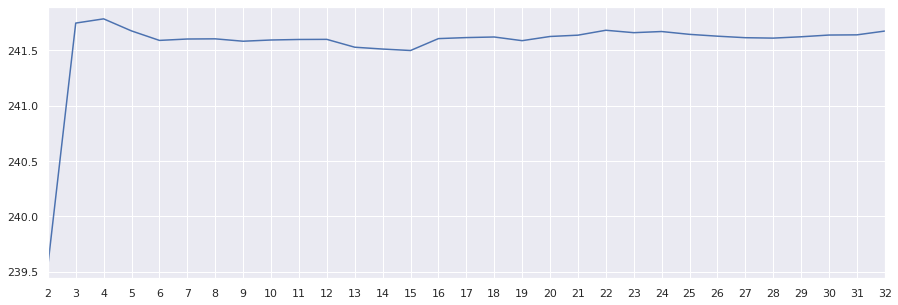

In [47]:
pd.Series(k_vs_score, index = range(2, 33, 1)).plot(figsize=(15,5), xticks=range(2, 33, 1));

In [48]:
selector = SelectKBest(score_func=f_regression, k=4)

selector.fit(X_train,y_train)

X_val.columns[selector.get_support()]

Index(['TP_PRESENCA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC'], dtype='object')

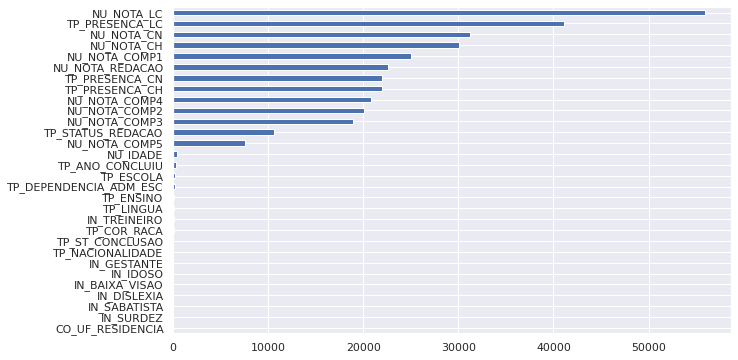

In [49]:
pd.Series(selector.scores_, index=X_train.columns).dropna().sort_values(ascending=True).plot.barh(figsize=(10,6));